In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import time
%matplotlib inline
#import evolution
from hbp_nrp_virtual_coach.virtual_coach import VirtualCoach
vc = VirtualCoach(environment='local')

INFO: [2018-01-28 16:10:51,111 - rospy.topics] topicmanager initialized


INFO: [2018-01-28 16:10:51,263 - Configuration] Loading configuration file config.json
INFO: [2018-01-28 16:10:51,265 - Configuration] Using user specified environment: local
INFO: [2018-01-28 16:10:51,321 - VirtualCoach] Ready.


## Helper Functions
Some helper functions to calculate the fitness function, plot the robot's trajectory and the wheel speeds. These functions are specific to this experiment.

In [2]:
def fitness_function(wheel_speeds):
    left_wheel = ([float(t[1]) for t in wheel_speeds[11:]])
    right_wheel = ([float(t[2]) for t in wheel_speeds[11:]])
    fitness = 0
    for i in range(len(left_wheel)):
        if left_wheel[i] >= 0 and right_wheel[i] >= 0:
                   fitness += (left_wheel[i] + right_wheel[i])
    return fitness/float(2*len(left_wheel))

def get_top_performers(population, fitness_log, num_performers=10):
    """
    Extract the indices of the top individuals from the fitness log.
    
    :param fitness_log: fitness function scores for all individuals in a population
    :param num_performers: number for top performers to look for. Default value is
                           15, which corresponds to a truncation threshold of 25% in
                           this experiment.
    """
    top_performers = []
    for i in range(num_performers):
        max_index = np.argmax(fitness_log)
        print max_index
        top_performers.append(population[max_index])
        fitness_log[max_index] = -1

    return top_performers

def plot_trajectory(trajectory):
    plt.figure()
    plt.gca()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylim(-3, 3)
    plt.xlim(-3.9, 3.9)
    x_axis = [x[0] for x in trajectory[2:]]
    y_axis = [y[1] for y in trajectory[2:]]
    plt.plot([float(x) for x in x_axis], [float(y) for y in y_axis])

def plot_wheel_speeds(wheel_speeds):
    left_wheel = ([float(t[1]) for t in wheel_speeds[11:]])
    right_wheel = ([float(t[2]) for t in wheel_speeds[11:]])
    plt.plot(range(len(left_wheel)), left_wheel, 'b')
    plt.plot(range(len(right_wheel)), right_wheel, 'r')

Evolutionary Algorithm helper functions

In [3]:
def one_point_crossover(parent1, parent2):
        parent1 = parent1.reshape(290)
        parent2 = parent2.reshape(290)
        child1 = np.zeros(290, dtype=int)
        child2 = np.zeros(290, dtype=int)
        point = np.random.randint(len(parent1))
        for i in range(point):
            child1[i] = parent1[i]
            child2[i] = parent2[i]
        for i in range(point, 290):
            child1[i] = parent2[i]
            child2[i] = parent1[i]
        child1 = child1.reshape(10, 29)
        child2 = child2.reshape(10, 29)
        return child1, child2
    
def bit_mutation(population):
        for individual in population:
            individual = individual.reshape(290)
            for i in range(290):
                if np.random.rand() < 0.05:
                    individual[i] = 0 if individual[i] else 1
        return population
    
def get_unique_pairs(population):
    pairs = []
    for i in range(len(population)):
        for j in range(i+1, len(population)):
            pairs.append((i, j))
    return pairs
            
def evolve_new_generation(top_performers):
    population = []
    for i in range(len(top_performers)):
        for j in range(4):
            population.append(top_performers[i])
    pairs = get_unique_pairs(population)
    for i in pairs:
        if np.random.rand() < 0.1:
            parent1 = population[i[0]]
            parent2 = population[i[1] - 1]
            child1, child2 = one_point_crossover(parent1, parent2)
            population[i[0]] = child1
            population[i[1]] = child2

    population = bit_mutation(population)
    rand = np.random.randint(len(population))
    population[rand] = top_performers[0]
    return population

## The Brain
The PyNN script that creates the neural network stored as a string. A new binary genetic string that encodes the connections between neurons is passed on each run.

In [4]:
brain = """from hbp_nrp_cle.brainsim import simulator as sim
import numpy as np
import logging

logger = logging.getLogger(__name__)

dna = np.array([int(x) for x in '%s'.split(',')]).reshape(10, 29)

receptors = []
for r in range(1,19):
    receptors.append(np.nonzero(dna[:,r])[0])


def create_brain():

    NEURONPARAMS = {'v_rest': -60.5,
                    'tau_m': 4.0,
                    'tau_refrac': 2.0,
                    'tau_syn_E': 10.0,
                    'tau_syn_I': 10.0,
                    'e_rev_E': 0.0,
                    'e_rev_I': -75.0,
                    'v_thresh': -60.4,
                    'v_reset': -60.5}

    SYNAPSE_PARAMS = {"weight": 1.0,
                      "delay": 2.0}

    population = sim.Population(10, sim.IF_cond_alpha())
    population[0:10].set(**NEURONPARAMS)


    # Connect neurons
    CIRCUIT = population

    SYN = sim.StaticSynapse(**SYNAPSE_PARAMS)

    row_counter=0
    for row in dna:
    	logger.info(row)
        n = np.array(row)
        r_type = 'excitatory'
        if n[0]==0:
            r_type = 'inhibitory'
        for i in range(19,29):
            if n[i]==1:
                sim.Projection(presynaptic_population=CIRCUIT[row_counter:1+row_counter], postsynaptic_population=CIRCUIT[i-19:i-18], connector=sim.OneToOneConnector(), synapse_type=SYN, receptor_type=r_type)
        
        row_counter+=1

    sim.initialize(population, v=population.get('v_rest'))

    logger.debug("Circuit description: " + str(population.describe()))

    return population


circuit = create_brain()

"""

In [5]:
display_trial_tf = """@nrp.Robot2Neuron()
def display_trial_number(t):
    clientLogger.advertise('%s')
"""

## Run Experiment

In [6]:
class FloreanoExperiment(object):
    
    def __init__(self, population, generations):
        self.last_status = [None]
        self.population = population
        self.fitness_log = []
        self.sim = None
        self.started = False
        self.generations = generations
        self.sim_data = []

    def wait_condition(self, timeout, condition):
        start = time.time()
        while time.time() < start + timeout:
            time.sleep(0.25)
            if condition(self.last_status[0]):
                return
        raise Exception('Condition check failed')
        
    def on_status(self, status):
        self.last_status[0] = status
                 
    def save_simulation_data(self, trial):
        self.sim_data[trial].append([])
        wheel_speeds = self.sim.get_csv_data('wheel_speeds.csv')
        try:
            left_wheel = ([float(t[1]) for t in wheel_speeds[11:]])
        except Exception as inst:
            print(type(inst))
            print(inst.args)
            print(inst)
            for t in wheel_speeds:
                print(t)
        right_wheel = ([float(t[2]) for t in wheel_speeds[11:]])
        trajectory = self.sim.get_csv_data('robot_position.csv')
        fitness = fitness_function(wheel_speeds)
        self.sim_data[trial][-1] = {
            'fitness': fitness,
            'wheel_speeds': wheel_speeds,
            'left_wheel': left_wheel,
            'right_wheel': right_wheel,
            'trajectory': trajectory
        }

    def run_experiment(self):
        try:
            self.sim = vc.launch_experiment('floreano')
        except:
            time.sleep(1)
        self.sim.register_status_callback(self.on_status)
        for i in range(self.generations):
            self.sim_data.append([])
            for j in range(40):
                print("Generation {}, Population {}".format(i, j))
                genetic_string = ','.join(str(x) for x in population[j].ravel())
                self.sim.edit_brain(brain % genetic_string)
                self.sim.add_transfer_function(display_trial_tf % "Generation {}, Population {}".format(i, j) )
                self.sim.start()
                # run simulation for 40 seconds
                self.wait_condition(1000, lambda x: x['simulationTime'] > 40)
                self.sim.pause()
                self.save_simulation_data(i)
                self.sim.reset('full')
                self.wait_condition(100, lambda x: x['state'] == 'paused' and x['simulationTime'] == 0)
            self.fitness_log = [result['fitness'] for result in floreano_experiment.sim_data[i]]
            self.top_performers = get_top_performers(self.population, list(self.fitness_log))
            self.population = evolve_new_generation(self.top_performers)

In [ ]:
population = np.random.randint(2, size=(40, 10, 29)) # random population of 10 binary genetic strings
floreano_experiment = FloreanoExperiment(population, 16)
floreano_experiment.run_experiment()

INFO: [2018-01-28 16:10:56,873 - VirtualCoach] Preparing to launch floreano.
INFO: [2018-01-28 16:10:56,873 - VirtualCoach] Retrieving list of experiments.
INFO: [2018-01-28 16:10:56,894 - VirtualCoach] Retrieving list of available servers.
[{u'gzweb': {u'assets': u'http://localhost:8080/assets',
             u'nrp-services': u'http://localhost:8080',
             u'videoStreaming': u'http://localhost:8080/webstream/',
             u'websocket': u'ws://localhost:8080/gzbridge'},
  u'id': u'localhost',
  u'rosbridge': {u'websocket': u'ws://localhost:8080/rosbridge'},
  u'serverJobLocation': u'local'}]
INFO: [2018-01-28 16:10:56,899 - Simulation] Attempting to launch floreano on localhost.
INFO: [2018-01-28 16:11:05,396 - Simulation (floreano - localhost #0)] Simulation Successfully Created.
INFO: [2018-01-28 16:11:05,403 - Simulation (floreano - localhost #0)] Ready.
INFO: [2018-01-28 16:11:05,404 - Simulation (floreano - localhost #0)] Status callback registered.
Generation 0, Populati

INFO: [2018-01-28 16:12:37,253 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:12:37,261 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 16:12:37,261 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 16:12:37,267 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 16:13:19,302 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:13:19,305 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:13:19,306 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:13:19,335 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:13:19,370 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28

INFO: [2018-01-28 16:14:52,327 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 16:14:52,528 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 16:14:52,746 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 16:14:53,176 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 0, Population 5
INFO: [2018-01-28 16:14:53,428 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:14:53,433 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:14:53,434 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:14:53,441 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:14:53,445 - Simulation (floreano - localhost #0)]

INFO: [2018-01-28 16:17:07,478 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:17:07,487 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:17:07,509 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:17:07,525 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:17:07,546 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:17:07,572 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:17:07,575 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:17:07,576 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 16:17:08,512 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:17:08,513 - Simulation 

Generation 0, Population 10
INFO: [2018-01-28 16:18:43,236 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:18:43,243 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:18:43,244 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:18:43,252 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:18:43,257 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:18:43,262 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:18:43,684 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 16:18:43,685 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 16:18:43,690 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:18:43,698 - Simulation (floreano - lo

INFO: [2018-01-28 16:20:56,658 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:20:56,680 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:20:56,683 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:20:56,684 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 16:20:57,774 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:20:57,775 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 16:20:57,786 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 16:20:58,093 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 16:20:58,602 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 16:22:32,451 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:22:32,456 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:22:32,895 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 16:22:32,896 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 16:22:32,901 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:22:32,909 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 16:22:32,910 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 16:22:32,913 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 16:23:14,701 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:23:14,704 - Simulation 

INFO: [2018-01-28 16:24:47,087 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:24:47,088 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 16:24:47,091 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 16:24:47,502 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 16:24:47,872 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 16:24:48,074 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 16:24:48,302 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 16:24:48,735 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 0, Population 18
INFO: [20

INFO: [2018-01-28 16:26:20,418 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:26:20,426 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 16:26:20,427 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 16:26:20,430 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 16:27:02,715 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:27:02,719 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:27:02,719 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:27:02,744 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:27:02,765 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28

INFO: [2018-01-28 16:28:35,352 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 16:28:35,554 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 16:28:35,778 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 16:28:36,213 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 0, Population 23
INFO: [2018-01-28 16:28:36,465 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:28:36,470 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:28:36,470 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:28:36,477 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:28:36,482 - Simulation (floreano - localhost #0)

INFO: [2018-01-28 16:30:50,193 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:30:50,194 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:30:50,214 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:30:50,230 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:30:50,246 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:30:50,262 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:30:50,267 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:30:50,268 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 16:30:51,197 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:30:51,198 - Simulation 

Generation 0, Population 28
INFO: [2018-01-28 16:32:25,286 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:32:25,299 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:32:25,300 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:32:25,305 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:32:25,310 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:32:25,315 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:32:25,779 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 16:32:25,780 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 16:32:25,791 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:32:25,800 - Simulation (floreano - lo

INFO: [2018-01-28 16:34:38,630 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:34:38,648 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:34:38,652 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:34:38,652 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 16:34:39,626 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:34:39,628 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 16:34:39,638 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 16:34:39,941 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 16:34:40,348 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 16:36:13,267 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:36:13,271 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:36:13,673 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 16:36:13,674 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 16:36:13,687 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:36:13,696 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 16:36:13,697 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 16:36:13,701 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 16:36:56,487 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:36:56,501 - Simulation 

INFO: [2018-01-28 16:38:28,548 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:38:28,549 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 16:38:28,553 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 16:38:28,959 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 16:38:29,345 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 16:38:29,547 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 16:38:29,766 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 16:38:30,211 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 0, Population 36
INFO: [20

INFO: [2018-01-28 16:40:02,692 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:40:02,702 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 16:40:02,702 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 16:40:02,706 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 16:40:44,742 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:40:44,746 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:40:44,752 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:40:44,775 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:40:44,798 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28

INFO: [2018-01-28 16:42:17,656 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 16:42:17,858 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 16:42:18,078 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 16:42:18,485 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 1, Population 1
INFO: [2018-01-28 16:42:18,737 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:42:18,741 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:42:18,742 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:42:18,747 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:42:18,752 - Simulation (floreano - localhost #0)]

INFO: [2018-01-28 16:44:31,891 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:44:31,892 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:44:31,982 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:44:32,008 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:44:32,025 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:44:32,042 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:44:32,046 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:44:32,047 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 16:44:33,160 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:44:33,161 - Simulation 

Generation 1, Population 6
INFO: [2018-01-28 16:46:05,734 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:46:05,739 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:46:05,740 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:46:05,744 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:46:05,749 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:46:05,754 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:46:06,168 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 16:46:06,169 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 16:46:06,173 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:46:06,182 - Simulation (floreano - loc

INFO: [2018-01-28 16:48:19,954 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:48:19,975 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:48:19,979 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:48:19,980 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 16:48:20,918 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:48:20,920 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 16:48:20,930 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 16:48:21,234 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 16:48:21,607 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 16:49:54,206 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:49:54,211 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:49:54,677 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 16:49:54,678 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 16:49:54,684 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:49:54,695 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 16:49:54,696 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 16:49:54,700 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 16:50:36,484 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:50:36,488 - Simulation 

INFO: [2018-01-28 16:52:09,606 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:52:09,607 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 16:52:09,610 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 16:52:10,020 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 16:52:10,401 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 16:52:10,604 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 16:52:10,823 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 16:52:11,235 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 1, Population 14
INFO: [20

INFO: [2018-01-28 16:53:43,229 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:53:43,240 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 16:53:43,241 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 16:53:43,245 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 16:54:25,278 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:54:25,283 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:54:25,283 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:54:25,302 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:54:25,318 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28

INFO: [2018-01-28 16:55:57,793 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 16:55:57,994 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 16:55:58,215 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 16:55:58,629 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 1, Population 19
INFO: [2018-01-28 16:55:59,131 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:55:59,136 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:55:59,137 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:55:59,142 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:55:59,146 - Simulation (floreano - localhost #0)

INFO: [2018-01-28 16:58:13,073 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:58:13,074 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:58:13,095 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:58:13,117 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:58:13,139 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 16:58:13,155 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 16:58:13,159 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 16:58:13,160 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 16:58:14,070 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 16:58:14,070 - Simulation 

Generation 1, Population 24
INFO: [2018-01-28 16:59:48,051 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:59:48,055 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 16:59:48,056 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:59:48,061 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:59:48,067 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:59:48,072 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 16:59:48,521 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 16:59:48,522 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 16:59:48,527 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 16:59:48,536 - Simulation (floreano - lo

INFO: [2018-01-28 17:02:01,900 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:02:01,918 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:02:01,923 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:02:01,924 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:02:02,830 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:02:02,831 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:02:02,835 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:02:03,238 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:02:03,622 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 17:03:35,824 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:03:35,828 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:03:36,308 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:03:36,308 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:03:36,314 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:03:36,323 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:03:36,324 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:03:36,328 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:04:18,113 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:04:18,116 - Simulation 

INFO: [2018-01-28 17:05:51,454 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:05:51,455 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:05:51,458 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:05:51,864 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:05:52,238 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:05:52,439 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:05:52,660 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:05:53,104 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 1, Population 32
INFO: [20

INFO: [2018-01-28 17:07:26,597 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:07:26,605 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:07:26,606 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:07:26,610 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:08:08,645 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:08:08,649 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:08:08,650 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:08:08,670 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:08:08,689 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28

INFO: [2018-01-28 17:09:42,266 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:09:42,468 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:09:42,688 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:09:43,116 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 1, Population 37
INFO: [2018-01-28 17:09:43,618 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:09:43,623 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:09:43,624 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:09:43,629 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:09:43,634 - Simulation (floreano - localhost #0)

INFO: [2018-01-28 17:11:58,291 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:11:58,292 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:11:58,322 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:11:58,343 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:11:58,364 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:11:58,381 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:11:58,384 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:11:58,385 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:11:59,253 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:11:59,254 - Simulation 

Generation 2, Population 2
INFO: [2018-01-28 17:13:32,397 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:13:32,409 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:13:32,410 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:13:32,414 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:13:32,419 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:13:32,424 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:13:32,812 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:13:32,813 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:13:32,825 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:13:32,832 - Simulation (floreano - loc

INFO: [2018-01-28 17:15:46,271 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:15:46,289 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:15:46,292 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:15:46,293 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:15:47,183 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:15:47,184 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:15:47,196 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:15:47,500 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:15:47,879 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 17:17:20,254 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:17:20,259 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:17:20,711 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:17:20,711 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:17:20,716 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:17:20,727 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:17:20,727 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:17:20,732 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:18:03,517 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:18:03,520 - Simulation 

INFO: [2018-01-28 17:19:35,593 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:19:35,594 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:19:35,597 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:19:35,908 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:19:36,263 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:19:36,465 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:19:36,698 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:19:37,150 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 2, Population 10
INFO: [20

INFO: [2018-01-28 17:21:08,993 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:21:09,001 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:21:09,002 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:21:09,006 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:21:51,042 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:21:51,054 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:21:51,055 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:21:51,124 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:21:51,144 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28

INFO: [2018-01-28 17:23:23,814 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:23:24,018 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:23:24,242 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:23:24,663 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 2, Population 15
INFO: [2018-01-28 17:23:25,166 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:23:25,173 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:23:25,174 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:23:25,181 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:23:25,186 - Simulation (floreano - localhost #0)

INFO: [2018-01-28 17:25:39,047 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:25:39,048 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:25:39,079 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:25:39,100 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:25:39,128 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:25:39,144 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:25:39,147 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:25:39,148 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:25:40,099 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:25:40,100 - Simulation 

Generation 2, Population 20
INFO: [2018-01-28 17:27:13,243 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:27:13,256 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:27:13,256 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:27:13,262 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:27:13,267 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:27:13,272 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:27:13,714 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:27:13,715 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:27:13,727 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:27:13,735 - Simulation (floreano - lo

INFO: [2018-01-28 17:29:27,642 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:29:27,664 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:29:27,668 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:29:27,668 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:29:28,537 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:29:28,538 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:29:28,549 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:29:28,855 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:29:29,290 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 17:31:01,734 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:31:01,739 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:31:02,200 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:31:02,201 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:31:02,207 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:31:02,216 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:31:02,217 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:31:02,220 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:31:44,504 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:31:44,509 - Simulation 

INFO: [2018-01-28 17:33:16,448 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:33:16,449 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:33:16,456 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:33:16,763 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:33:17,193 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:33:17,395 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:33:17,619 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:33:18,045 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 2, Population 28
INFO: [20

INFO: [2018-01-28 17:34:49,975 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:34:49,983 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:34:49,984 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:34:49,988 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:35:32,025 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:35:32,038 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:35:32,039 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:35:32,076 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:35:32,105 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28

INFO: [2018-01-28 17:37:05,751 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:37:05,954 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:37:06,175 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:37:06,593 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 2, Population 33
INFO: [2018-01-28 17:37:06,845 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:37:06,855 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:37:06,856 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:37:06,862 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:37:06,867 - Simulation (floreano - localhost #0)

INFO: [2018-01-28 17:39:21,362 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:39:21,363 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:39:21,387 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:39:21,413 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:39:21,428 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:39:21,445 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:39:21,448 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:39:21,449 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:39:22,390 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:39:22,400 - Simulation 

Generation 2, Population 38
INFO: [2018-01-28 17:40:58,258 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:40:58,263 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:40:58,263 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:40:58,271 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:40:58,276 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:40:58,281 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:40:58,679 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:40:58,680 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:40:58,692 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:40:58,706 - Simulation (floreano - lo

INFO: [2018-01-28 17:43:12,852 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:43:12,868 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:43:12,871 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:43:12,872 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:43:13,785 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:43:13,786 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:43:13,796 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:43:14,200 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:43:14,618 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 17:44:46,954 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:44:46,958 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:44:47,392 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:44:47,392 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:44:47,398 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:44:47,407 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:44:47,408 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:44:47,411 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:45:30,698 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:45:30,703 - Simulation 

INFO: [2018-01-28 17:47:02,944 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:47:02,955 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:47:02,956 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:47:03,359 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:47:03,788 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:47:03,989 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:47:04,211 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:47:04,647 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 3, Population 6
INFO: [201

INFO: [2018-01-28 17:48:37,306 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:48:37,307 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:48:37,313 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:49:19,348 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:49:19,352 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:49:19,357 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:49:19,409 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:49:19,439 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:49:19,454 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018

INFO: [2018-01-28 17:50:54,038 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 17:50:54,265 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 17:50:54,715 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 3, Population 11
INFO: [2018-01-28 17:50:55,718 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:50:55,730 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:50:55,730 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:50:55,735 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:50:55,739 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:50:55,745 - Simulation (floreano - localhost #0)] Attempting to retr

INFO: [2018-01-28 17:53:14,383 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:53:14,441 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:53:14,472 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:53:14,497 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:53:14,516 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:53:14,520 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:53:14,521 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:53:15,447 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:53:15,448 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 1

INFO: [2018-01-28 17:54:54,492 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 17:54:54,493 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:54:54,497 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:54:54,504 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:54:54,508 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 17:54:54,914 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:54:54,915 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:54:54,927 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:54:54,936 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:54:54,937 - Simulation (floreano - localhost #0)] At

INFO: [2018-01-28 17:57:16,263 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:57:16,266 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:57:16,267 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 17:57:17,249 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 17:57:17,250 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 17:57:17,253 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 17:57:17,556 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 17:57:17,953 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 17:57:18,156 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [

INFO: [2018-01-28 17:58:55,425 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 17:58:55,426 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 17:58:55,439 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 17:58:55,448 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 17:58:55,449 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 17:58:55,457 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 17:59:40,754 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 17:59:40,761 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 17:59:40,762 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 17:59:40,815 - S

INFO: [2018-01-28 18:01:15,992 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 18:01:16,299 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 18:01:16,670 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 18:01:16,873 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 18:01:17,107 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 18:01:17,582 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 3, Population 24
INFO: [2018-01-28 18:01:18,084 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:01:18,089 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 18:01:18,090 - S

INFO: [2018-01-28 18:02:57,456 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 18:02:57,460 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 18:03:39,494 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 18:03:39,499 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 18:03:39,499 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:03:39,517 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:03:39,534 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:03:39,550 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:03:39,569 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018

INFO: [2018-01-28 18:05:14,388 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 18:05:14,835 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 3, Population 29
INFO: [2018-01-28 18:05:15,087 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:05:15,099 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 18:05:15,099 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:05:15,105 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:05:15,110 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:05:15,116 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:05:15,607 - Simulation (floreano - localhost #0)] Brain successfully updated.
INF

INFO: [2018-01-28 18:07:30,479 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:07:30,509 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:07:30,534 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:07:30,552 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 18:07:30,556 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 18:07:30,556 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 18:07:31,486 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 18:07:31,487 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 18:07:31,489 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-

INFO: [2018-01-28 18:09:07,787 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:09:07,794 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:09:07,800 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:09:07,807 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:09:08,330 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 18:09:08,331 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 18:09:08,336 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 18:09:08,345 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 18:09:08,345 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 18:09:08,349 - Simulation (floreano 

INFO: [2018-01-28 18:11:25,999 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 18:11:26,000 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 18:11:27,636 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 18:11:27,636 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 18:11:27,646 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 18:11:28,051 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 18:11:28,438 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 18:11:28,640 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 18:11:28,869 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
IN

INFO: [2018-01-28 18:13:01,249 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 18:13:01,254 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 18:13:01,263 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 18:13:01,264 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 18:13:01,268 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 18:13:44,055 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 18:13:44,059 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 18:13:44,060 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:13:44,082 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 1

INFO: [2018-01-28 18:15:16,868 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 18:15:17,248 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: [2018-01-28 18:15:17,449 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: plane
INFO: [2018-01-28 18:15:17,670 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the brain
INFO: [2018-01-28 18:15:18,096 - Simulation (floreano - localhost #0)] Reset completed. The simulation has been paused and will not be startedautomatically.
Generation 4, Population 2
INFO: [2018-01-28 18:15:18,598 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:15:18,603 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 18:15:18,604 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:15:18,611 - Simulation (floreano - 

INFO: [2018-01-28 18:17:36,455 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 18:17:36,461 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 18:17:36,462 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:17:36,502 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:17:36,529 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:17:36,557 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:17:36,575 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 18:17:36,578 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 18:17:36,579 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 18:17:37,620

Generation 4, Population 7
INFO: [2018-01-28 18:19:28,080 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:19:28,096 - Simulation (floreano - localhost #0)] Attempting to set Brain
INFO: [2018-01-28 18:19:28,097 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:19:28,103 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:19:28,108 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:19:28,113 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:19:29,420 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 18:19:29,421 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 18:19:29,426 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 18:19:29,435 - Simulation (floreano - loc

INFO: [2018-01-28 18:21:58,061 - Simulation (floreano - localhost #0)] Attempting to retrieve recorders' csv data
INFO: [2018-01-28 18:21:58,081 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 18:21:58,084 - Simulation (floreano - localhost #0)] Simulation state: paused
INFO: [2018-01-28 18:21:58,085 - Simulation (floreano - localhost #0)] Attempting to reset full
INFO: [2018-01-28 18:21:59,078 - Simulation (floreano - localhost #0)] [Resetting the simulation] 
INFO: [2018-01-28 18:21:59,079 - Simulation (floreano - localhost #0)] [Resetting the simulation] Restoring the 3D world
INFO: [2018-01-28 18:21:59,084 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: pointlight_0
INFO: [2018-01-28 18:21:59,390 - Simulation (floreano - localhost #0)] [Resetting the simulation] Deleting: plane
INFO: [2018-01-28 18:21:59,760 - Simulation (floreano - localhost #0)] [Resetting the simulation] Loading: pointlight_0
INFO: 

INFO: [2018-01-28 18:23:37,002 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:23:37,010 - Simulation (floreano - localhost #0)] Attempting to retrieve brain
INFO: [2018-01-28 18:23:37,483 - Simulation (floreano - localhost #0)] Brain successfully updated.
INFO: [2018-01-28 18:23:37,484 - Simulation (floreano - localhost #0)] Attempting to retrieve transfer-function
INFO: [2018-01-28 18:23:37,493 - Simulation (floreano - localhost #0)] Attempting to set Transfer Function 
INFO: [2018-01-28 18:23:37,502 - Simulation (floreano - localhost #0)] Transfer Function '' successfully updated
INFO: [2018-01-28 18:23:37,503 - Simulation (floreano - localhost #0)] Attempting to transition to state: started
INFO: [2018-01-28 18:23:37,510 - Simulation (floreano - localhost #0)] Simulation state: started
INFO: [2018-01-28 18:24:21,304 - Simulation (floreano - localhost #0)] Attempting to transition to state: paused
INFO: [2018-01-28 18:24:21,309 - Simulation 

TypeError: list indices must be integers, not str

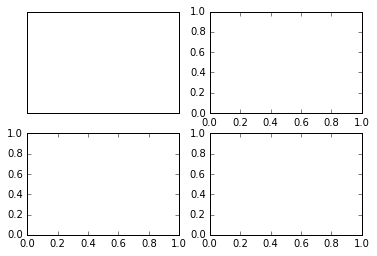

In [8]:
fig, axes = plt.subplots(len(floreano_experiment.sim_data), 2)
for i in range(len(floreano_experiment.sim_data)):
    axes[i, 0].set_ylim(-3, 3)
    axes[i, 0].set_xlim(-3.9, 3.9)
    axes[i, 0].set_xticks([], [])
    axes[i, 0].set_yticks([], [])
    x_axis = [x[0] for x in floreano_experiment.sim_data[i]['trajectory'][2:]]
    y_axis = [y[1] for y in floreano_experiment.sim_data[i]['trajectory'][2:]]
    axes[i, 0].plot([float(x) for x in x_axis], [float(y) for y in y_axis])

    left_wheel = ([float(t[1]) for t in floreano_experiment.sim_data[i]['wheel_speeds'][2:]])
    right_wheel = ([float(t[2]) for t in floreano_experiment.sim_data[i]['wheel_speeds'][2:]])
    axes[i, 1].plot(range(len(left_wheel)), left_wheel, 'b', label='Left Wheel')
    axes[i, 1].plot(range(len(right_wheel)), right_wheel, 'r', label='Right Wheel')
    axes[i, 1].set_ylim(-5, 5)
    axes[i, 1].set_xlabel('Time [ms]')
    axes[i, 1].set_ylabel('Speed m/s')

axes[0, 0].set_title('Robot Trajectory')
axes[0, 1].set_title('Wheel Speeds')
fig.set_figheight(25)
fig.set_figwidth(10)
